## Using GPU's on IBM POWER S822LC 
![](https://github.com/dustinvanstee/random-public-files/raw/master/s822lc_nvidia.png)

In this lab, you will familiarize yourself with how to compare GPU vs CPU performance using some simple matrix math.  We will cover how tensorflow gives access to GPU and CPU, and how you can specify to the system when they can be used.

You don't need to know tensorflow to complete this lab, but understanding some of tensorflow basics and matrix math will help.

### Let's get started, first lets import the tensorflow library that has been provided by the IBM PowerAI library.

In [1]:
import tensorflow as tf
import math
# Time helper
import timeit

# Print Python Version
import os
import sys
print(sys.version)
import gpulab_funcs 


2.7.12 (default, Dec  4 2017, 14:50:18) 
[GCC 5.4.0 20160609]


### Verify GPU Usage with Small Matrix
Now lets build a few small matrixes and multiply them together.  Here A is 2x3 matrix, an B is 3x2 matrix.  Then we multiply them together.  By default tensorflow will use the GPU on the system if available.  Lets run this code and verify that we are using the GPU.

Note : To find out which devices your operations and tensors are assigned to, create the session with log_device_placement configuration option set to True as shown below.  

In [2]:
%%time
# Creates a graph.
tf.reset_default_graph() 
with tf.device('/gpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
  c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
with tf.Session() as sess :
    writer = tf.summary.FileWriter('./graphs', graph=tf.get_default_graph())
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    # Runs the op.
    print(sess.run(c))
    sess.close()

[[22. 28.]
 [49. 64.]]
CPU times: user 148 ms, sys: 96 ms, total: 244 ms
Wall time: 1.19 s


When we started the jupyter notebook, we also redirected all the messages to a log file so that we can see if indeed we are using the GPU.  Let's read the last couple of lines in the log file (/tmp/tensorflow.log).

Look for `gpu:0` 

In [3]:
%%bash
tail -n 10 /tmp/tensorflow.log | grep gpu
#echo " ############" >>  /tmp/tensorflow.log 

2018-01-28 18:44:30.543586: I tensorflow/core/common_runtime/simple_placer.cc:841] b: (Const)/job:localhost/replica:0/task:0/gpu:0
2018-01-28 18:44:30.543611: I tensorflow/core/common_runtime/simple_placer.cc:841] a: (Const)/job:localhost/replica:0/task:0/gpu:0


Here you can see that 3 operations were assigned to gpu:0.  Two constant assignments a,b, and a matrix multiply (MatMul).

### Verify that we can use the CPU as well with same example

Here we will specify explicitly that we want to use the CPU.  By convention, tensorflow allows you to specify that by using the tf.device() method.

Devices are represented by the following strings

* /cpu:0 : The first cpu of your machine
* /gpu:0 : The first gpu of your machine
* /gpu:1 : The second gpu of your machine
* ...
* ...

In this cell we specify **/cpu:0** with the exact same code.

In [4]:
%%time
tf.reset_default_graph() 
# Creates a graph.
with tf.device('/cpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
  c = tf.matmul(a, b)

# Creates a session with log_device_placement set to True.
with tf.Session() as sess :
    writer = tf.summary.FileWriter('./graphs', graph=tf.get_default_graph())
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    # Runs the op.
    print(sess.run(c))
    sess.close()

[[22. 28.]
 [49. 64.]]
CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 32.9 ms


Now let's make sure that we used the cpu ...

In [5]:
%%bash
tail -n 10 /tmp/tensorflow.log | grep cpu

2018-01-28 18:44:38.562639: I tensorflow/core/common_runtime/simple_placer.cc:841] MatMul: (MatMul)/job:localhost/replica:0/task:0/cpu:0
2018-01-28 18:44:38.562663: I tensorflow/core/common_runtime/simple_placer.cc:841] b: (Const)/job:localhost/replica:0/task:0/cpu:0
2018-01-28 18:44:38.562689: I tensorflow/core/common_runtime/simple_placer.cc:841] a: (Const)/job:localhost/replica:0/task:0/cpu:0


Notice here that now we are mapping all the operations to the cpu. 


Also notice we don't really get a large speedup.  That's because the example is to small to make use of the parallelism advantage inherent in the GPU.  Next, we will rerun but this time will very large matrices.

### GPU Speedup test with 20 Billion cells

Here we change the matrices to be sets of randomly distributed values, and multiply them together.  The resultant matrix from the mat1 * mat2 operation will be a 20000 x 10000 matrix.  Run this cell and notice the run time to be approx ~1 s (run this cell a couple times to get a feel for the average).

In [6]:
%%time
tf.reset_default_graph() 

mat1 = tf.random_normal([20000,10000],mean=0.0, stddev=1.0, dtype=tf.float32)
mat2 = tf.random_normal([10000,10000],mean=0.0, stddev=1.0, dtype=tf.float32)
mat3 = tf.matmul(mat1, mat2)

# Creates a session with log_device_placement set to True.
with tf.Session() as sess :
    writer = tf.summary.FileWriter('./graphs', graph=tf.get_default_graph())
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    # Runs the op.
    sess.run(mat3)
    sess.close()

CPU times: user 1.79 s, sys: 448 ms, total: 2.24 s
Wall time: 27.3 s


### CPU test with 20 Billion cells
Now lets perform the same operation with CPU only.  

If you were to check vmstat on your terminal, you would notice that all 32 CPU cores are working to multiply this matrix.   You can verify this by running <p>
**`vmstat 3`** <p> at the terminal in your other browser window you had setup.

Sample output will show 32 processes running in parallel on the cpus. <p>
`32  0 1433856 129245184      0     80    0    0     0     0 11183 5409 100  0  0  0  0`

In [19]:
%%time
tf.reset_default_graph() 

with tf.device('/cpu:0'):
    mat1 = tf.random_normal([20000,10000],mean=0.0, stddev=1.0, dtype=tf.float32)
    mat2 = tf.random_normal([10000,10000],mean=0.0, stddev=1.0, dtype=tf.float32)
    mat3 = tf.matmul(mat1, mat2)

    # Creates a session with log_device_placement set to True.
with tf.Session() as sess :
    writer = tf.summary.FileWriter('./graphs', graph=tf.get_default_graph())
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    # Runs the op.
    sess.run(mat3)
    sess.close()

CPU times: user 17min 35s, sys: 1.34 s, total: 17min 36s
Wall time: 33.3 s


*** Notice we achieved between a 30 to 50x speedup with the GPU for this testcase! ***

### Lets find the knee of the curve

For this exercise, manually populate different values within the runs list, and then plot the results.  Determine the knee of the curve.  The knee is the location where the size of the matrix can start to exploit the parallelism offered by the GPU.  Try to run the cell below to get a feel for multiply square matrices of 10,100.

Max run size should be less than 25000 to finish within a reasonable time


 <div class="panel-group" id="accordion-11">
  <div class="panel panel-default">
    <div class="panel-heading">
      <h4 class="panel-title">
        <a data-toggle="collapse" data-parent="#accordion-11" href="#collapse1-11">
        Answer</a>
      </h4>
    </div>
    <div id="collapse1-11" class="panel-collapse collapse">
      <div class="panel-body">modify runs = [10,100,300,700,1000,3000,7000,10000,13000,17000] </div>
    </div>
  </div>
</div> 

In [22]:
%%time

### Edit code below this line
matrix_sizes =  [10,100,1000,10000]  # this is the 
### Dont edit code below this line


# ratios will be populated via the getRatio function
ratios = []
for i in matrix_sizes :
    ratios.append(gpulab_funcs.getRatio(i))

print matrix_sizes
print ratios

[10, 100, 1000, 10000]
[0.9101214410462614, 0.7905855139966326, 2.013860800078923, 45.485598832252926]
CPU times: user 8min 46s, sys: 764 ms, total: 8min 47s
Wall time: 17.7 s


### Plot your results here
Your array sizes were saved in the matrix_sizes list, and ratios were saved in the ratios list.  Lets plot the results to determine where the knee of the curve is.  

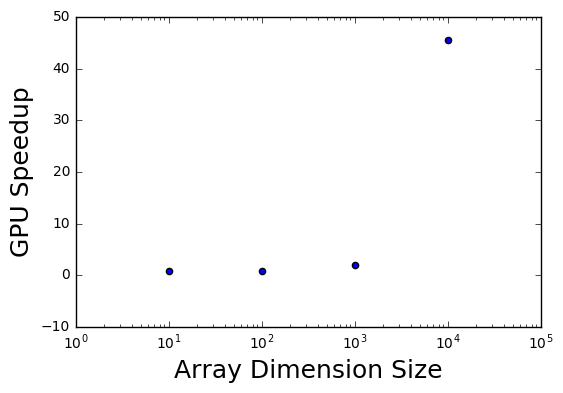

In [23]:
import matplotlib.pyplot
%matplotlib inline

matplotlib.pyplot.scatter(matrix_sizes,ratios)
matplotlib.pyplot.xscale('log')
matplotlib.pyplot.xlabel('Array Dimension Size', fontsize=18)
matplotlib.pyplot.ylabel('GPU Speedup', fontsize=18)
matplotlib.pyplot.show()

# note , run this cell twice.  for some reason the first time does not plot the graph ...


### Summary

In this lab you were able to see how to use tensorflow and see how a GPU can speed up matrix multiplication operations.  In general, matrix operations are used frequently in machine learning algorithms, and hence the GPU capability will speed a number of ML algorithms.  In the next labs we will be exclusively using the GPU for image classification and churn examples. 



useful stackoverflows that contributed to this lab<p>
https://stackoverflow.com/questions/46178961/duplicate-tensorflow-placeholder-variables<p>
https://stackoverflow.com/questions/37660312/run-tensorflow-on-cpu